In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
!pip install stop_words
nltk.download('stopwords')
import pickle

from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
#!pip install stop_words

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=72286e8ab2e0799f33c9317ee65b25735d5df661463e31af9fb4cb1e4e2228fe
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/Shareddrives/ presentation/text_emotion.csv')
df

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print('Num of numerical variables: {}\n'.format(len(numerical)))
print('The numerical variables are: ', numerical)

Num of numerical variables: 1

The numerical variables are:  ['tweet_id']


In [6]:
df = df.drop(columns=['tweet_id','author'])

In [7]:
duplicates_count = df.duplicated().sum()
print(f'Total duplicated rows: {duplicates_count}')

Total duplicated rows: 91


In [8]:
df[df['content'].duplicated() == True]

,sentiment,content
366,worry,I feel so deflated. No more doggy.
521,worry,Somebody please save the polar bears!
1026,neutral,I'm at work
3684,sadness,@dublins98dave me too! I am down 400 euro
4363,worry,"is upset, I left my phone at home again"
...,...,...
39859,love,Happy Mothers Day
39898,love,happy mothers day!
39913,happiness,happy mother's day!
39915,love,happy mother's day everyone


In [9]:
index = df[df['content'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

In [10]:
df.shape

(39827, 2)

In [11]:
# Unique values from 'sentiment'
unique_sentiments = df['sentiment'].unique()
print(unique_sentiments)

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [12]:
frequency_counts = df['sentiment'].value_counts()

frequency_percentage = (frequency_counts / len(df['sentiment'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Print total value
cardinality = df['sentiment'].nunique()
print(f"\ntotal values: {cardinality}")


            Counts  Percentage
neutral       8598   21.588370
worry         8437   21.184121
happiness     5184   13.016295
sadness       5154   12.940970
love          3785    9.503603
surprise      2181    5.476184
fun           1775    4.456776
relief        1522    3.821528
hate          1322    3.319356
empty          822    2.063926
enthusiasm     758    1.903231
boredom        179    0.449444
anger          110    0.276195

total values: 13


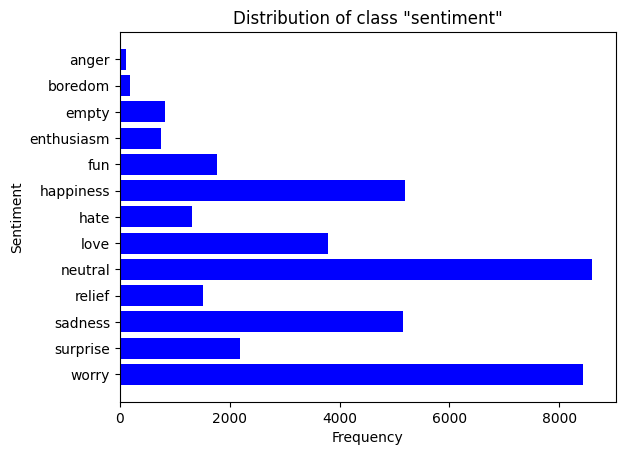

In [13]:
sentiment_counts = df['sentiment'].value_counts().sort_index()

sentiments = sentiment_counts.index
frequencies = sentiment_counts.values
total = sum(frequencies)
# Plot
plt.barh(sentiments, frequencies, color='blue')
plt.xlabel('Frequency')
plt.ylabel('Sentiment')
plt.title('Distribution of class "sentiment"')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest sentiment at the top

for index, value in enumerate(frequencies):
    percentage = (value / total) * 100

plt.show()

In [14]:
sentiment_mapping = {
    'empty': 'negative',
    'sadness': 'negative',
    'worry': 'negative',
    'hate': 'negative',
    'boredom': 'negative',
    'anger': 'negative',
    'enthusiasm': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'love': 'positive',
    'fun': 'positive',
    'happiness': 'positive',
    'relief': 'positive'
}

# Create a new col for the mapping
df['label'] = df['sentiment'].map(sentiment_mapping)

In [15]:
# Drop the original column, 'sentiment'
df = df.drop(columns=['sentiment'])

In [16]:
unique_sentiments = df['label'].unique()
print(unique_sentiments)

['negative' 'positive' 'neutral']


In [17]:
df.head(5)

,content,label
0,@tiffanylue i know i was listenin to bad habi...,negative
1,Layin n bed with a headache ughhhh...waitin o...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,@dannycastillo We want to trade with someone w...,neutral


In [18]:
frequency_counts = df['label'].value_counts()

frequency_percentage = (frequency_counts / len(df['label'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Total value count
cardinality = df['label'].nunique()
print(f"\ntotal values: {cardinality}")

          Counts  Percentage
negative   16024   40.234012
positive   13024   32.701434
neutral    10779   27.064554

total values: 3


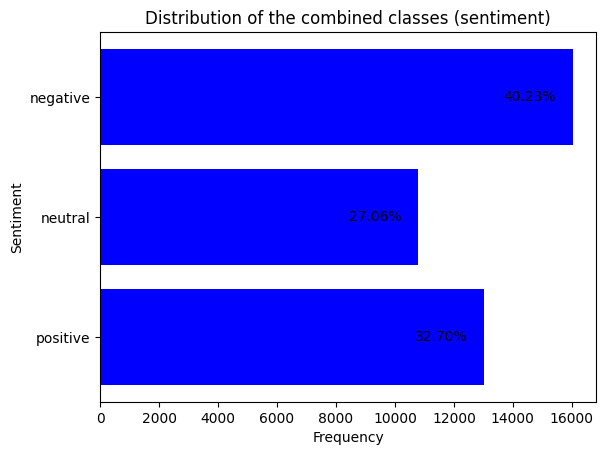

In [19]:
sentiment_counts = df['label'].value_counts().sort_index()

# Extract sentiment values & frequencies
sentiments = sentiment_counts.index
frequencies = sentiment_counts.values

total = sum(frequencies)  # Calculate the total frequency

plt.barh(sentiments, frequencies, color='blue')
plt.xlabel('Frequency')
plt.ylabel('Sentiment')
plt.title('Distribution of the combined classes (sentiment)')
plt.gca().invert_yaxis()

# Annotate each bar with its percentage
for index, value in enumerate(frequencies):
    percentage = (value / total) * 100
    plt.text(value - (max(frequencies) * 0.09), index, f'{percentage:.2f}%', ha='center', va='center', color='black')

plt.show()

In [20]:
# Mapping sentiment num / encode
df["label_num"] = df.label.map({
    'negative': 0,
    'positive': 1,
    'neutral': 2
})

df = df.drop(columns=['label'])
df.head(5)

,content,label_num
0,@tiffanylue i know i was listenin to bad habi...,0
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,1
4,@dannycastillo We want to trade with someone w...,2


In [21]:
X = df['content']
y = df['label_num']

# Making sure that X y have the same length
print(len(X))
print(len(y))

39827
39827


Cleaning and lemmatising

In [22]:
# Cleaning and lemmatising
cleaned = []

for sen in range(0, len(X)):
    # Remove all the special characters (any letter or a digit)
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters (surrounded by whitespace)
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization- splits into list of words ['The', 'quick', ....]
    document = document.split()

    lemma = WordNetLemmatizer()
    document = [lemma.lemmatize(word) for word in document]
    document = ' '.join(document)
    cleaned.append(document)


In [23]:
len(cleaned)

39827

In [24]:
# Count stopwords present in the data
nltk.download('punkt')
def count_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = nltk.word_tokenize(text)
    return len(set(words) & stop_words)

# Add a new col 'stop_words' that contains the count of stopwords
df['stop_words'] = df['content'].apply(count_stopwords)
value_counts = df['stop_words'].value_counts()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# Count the number of stopwords in the data
temp = df.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['content'].apply(lambda x: len(set(x.split()) & stop_words))

# Print rows that contain stopwords
rows_with_stopwords = temp[temp['stop_words'] > 0]
print(rows_with_stopwords)

                                                 content  label_num  \
0      @tiffanylue i know  i was listenin to bad habi...          0   
1      Layin n bed with a headache  ughhhh...waitin o...          0   
3                   wants to hang out with friends SOON!          1   
4      @dannycastillo We want to trade with someone w...          2   
5      Re-pinging @ghostridah14: why didn't you go to...          0   
...                                                  ...        ...   
39819  @jasimmo Ooo showing of your French skills!! l...          2   
39820  @sendsome2me haha, yeah. Twitter has many uses...          2   
39823                     Happy Mothers Day  All my love          1   
39824  Happy Mother's Day to all the mommies out ther...          1   
39826  @mopedronin bullet train from tokyo    the gf ...          1   

       stop_words  
0               6  
1               4  
3               3  
4               6  
5               5  
...           ...  
39819  

In [26]:
# Explore tweet that contains stopwords
df['content'][4]

'@dannycastillo We want to trade with someone who has Houston tickets, but no one will.'

In [27]:
# Count stopwords in index 4
stop_words = set(stopwords.words("english"))
df_indx = df['content'][4]
stopword_count = len([word for word in df_indx.split() if word in stop_words])
stopword_count

6

In [28]:
# Print all the stopwords in index 3
stopwords_in_content = [word for word in df_indx.split() if word in stop_words]

print("Stopwords in df['content'][4]:")
print(stopwords_in_content)

'''
The cleaned sentence from 5th row, ['@dannycastillo We want to trade with someone who has Houston tickets, but no one will.']
contains 6 stopwords, 'to', 'with', 'who', 'has', 'but' and 'no'
'''

Stopwords in df['content'][4]:
['to', 'with', 'who', 'has', 'but', 'no']


"\nThe cleaned sentence from 5th row, ['@dannycastillo We want to trade with someone who has Houston tickets, but no one will.']\ncontains 6 stopwords, 'to', 'with', 'who', 'has', 'but' and 'no'\n"

In [29]:
cleaned_tokenized = []
for each in cleaned:
    doc = sent_tokenize(each)
    for sentence in doc:
        cleaned_tokenized.append(sentence)

# Type and length of the cleaned & tokenised sentence
print(type(cleaned_tokenized))
print(len(cleaned_tokenized))

# Print the fist 15 lines of the cleaned & tokenised sentence
for i in range(15):
  print(cleaned_tokenized[i])

<class 'list'>
39827
tiffanylue know wa listenin to bad habit earlier and started freakin at his part
layin bed with headache ughhhh waitin on your call
funeral ceremony gloomy friday
want to hang out with friend soon
dannycastillo we want to trade with someone who ha houston ticket but no one will
re pinging ghostridah14 why didn you go to prom bc my bf didn like my friend
i should be sleep but im not thinking about an old friend who want but he married now damn amp he want me 2 scandalous
hmmm http www djhero com is down
charviray charlene my love miss you
kelcouch m sorry at least it friday
cant fall asleep
choked on her retainer
ugh have to beat this stupid song to get to the next rude
brodyjenner if watch the hill in london will realise what tourture it is because were week and week late just watch itonlinelol
got the news


In [30]:
# Crate a new colum that contains processed text
df['processed_content'] = cleaned_tokenized

# Reorder col
desired_order = ['content', 'processed_content', 'label_num']
df = df[desired_order]
df.head(10)

X = cleaned_tokenized

In [31]:
# Pick a random row, count SW in that sentence
df.loc[4]

content              @dannycastillo We want to trade with someone w...
processed_content    dannycastillo we want to trade with someone wh...
label_num                                                            2
Name: 4, dtype: object

In [32]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.transform(X)      # CV sparse matrix

tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix) # tf-idf sparse matrix
print(tf_idf_matrix)
dense_tf_idf_matrix = tf_idf_matrix.toarray()         # tf-idf dense matrix
#print(dense_tf_idf_matrix)

X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, y, test_size=0.2, random_state=42)

  (0, 43332)	0.1518430710131997
  (0, 41022)	0.0895824439978616
  (0, 40780)	0.43759297037282197
  (0, 38272)	0.2809320032082203
  (0, 30725)	0.2715694620029922
  (0, 24264)	0.3691487480479141
  (0, 22883)	0.17615179493195804
  (0, 18455)	0.22714117417894344
  (0, 17484)	0.3729753727357813
  (0, 15602)	0.3173168036531972
  (0, 13049)	0.29844654766636164
  (0, 4791)	0.20482508711692113
  (0, 4298)	0.15015333688570337
  (0, 3306)	0.11177953914231517
  (1, 45363)	0.20621500623039635
  (1, 44287)	0.1770042446996165
  (1, 43397)	0.4263381944502906
  (1, 42241)	0.4521658225761395
  (1, 29966)	0.16170916077980185
  (1, 23608)	0.5107676060309795
  (1, 17962)	0.31660908479058814
  (1, 7480)	0.2921072110922723
  (1, 5332)	0.2594712816784557
  (2, 16689)	0.5095909158870481
  (2, 15882)	0.5295829974812808
  :	:
  (39825, 20020)	0.36461462291757374
  (39825, 19581)	0.10287364461604477
  (39825, 18463)	0.22248799183431808
  (39825, 15333)	0.19835744687310317
  (39825, 11351)	0.2670052575309654
  (39

NameError: name 'tf_idf_matrix' is not defined

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have X and y from the previous code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad the sequences
max_words = 500
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 50, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))

# Evaluate the model
cnn_score = cnn_model.evaluate(X_test_pad, y_test)
print(f"\nCNN Model - Test Loss: {cnn_score[0]}, Test Accuracy: {cnn_score[1]}")
from sklearn.metrics import f1_score
y_pred = cnn_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"CNN Model - F1 Score: {f1}")


Epoch 1/5
996/996 [==============================] - 25s 24ms/step - loss: 0.9523 - accuracy: 0.5473 - val_loss: 0.9223 - val_accuracy: 0.5726
Epoch 2/5
996/996 [==============================] - 24s 24ms/step - loss: 0.8996 - accuracy: 0.5861 - val_loss: 0.9135 - val_accuracy: 0.5788
Epoch 3/5
996/996 [==============================] - 24s 24ms/step - loss: 0.8724 - accuracy: 0.6016 - val_loss: 0.9193 - val_accuracy: 0.5775
Epoch 4/5
996/996 [==============================] - 24s 24ms/step - loss: 0.8376 - accuracy: 0.6229 - val_loss: 0.9365 - val_accuracy: 0.5699
Epoch 5/5
249/249 [==============================] - 2s 7ms/step - loss: 0.9643 - accuracy: 0.5675

CNN Model - Test Loss: 0.9642693400382996, Test Accuracy: 0.5675370097160339
249/249 [==============================] - 2s 9ms/step
CNN Model - F1 Score: 0.5575829541357087


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have X and y from the previous code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad the sequences
max_words = 500
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 100, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))  # Add dropout for regularization
cnn_model.add(Dense(64, activation='relu'))  # Add an additional dense layer
cnn_model.add(Dropout(0.5))  # Another dropout layer
cnn_model.add(Dense(3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the model
cnn_score = cnn_model.evaluate(X_test_pad, y_test)
print(f"\nCNN Model - Test Loss: {cnn_score[0]}, Test Accuracy: {cnn_score[1]}")

# Make predictions and calculate F1 score
y_pred = cnn_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"CNN Model - F1 Score: {f1}")


Epoch 1/10
996/996 [==============================] - 42s 41ms/step - loss: 0.9852 - accuracy: 0.5226 - val_loss: 0.9301 - val_accuracy: 0.5657
Epoch 2/10
996/996 [==============================] - 46s 46ms/step - loss: 0.9313 - accuracy: 0.5719 - val_loss: 0.9209 - val_accuracy: 0.5767
Epoch 3/10
996/996 [==============================] - 41s 41ms/step - loss: 0.9155 - accuracy: 0.5829 - val_loss: 0.9198 - val_accuracy: 0.5777
Epoch 4/10
996/996 [==============================] - 40s 41ms/step - loss: 0.8994 - accuracy: 0.5908 - val_loss: 0.9176 - val_accuracy: 0.5758
Epoch 5/10
996/996 [==============================] - 41s 42ms/step - loss: 0.8815 - accuracy: 0.6012 - val_loss: 0.9184 - val_accuracy: 0.5716
Epoch 6/10
996/996 [==============================] - 41s 42ms/step - loss: 0.8657 - accuracy: 0.6112 - val_loss: 0.9239 - val_accuracy: 0.5694
Epoch 7/10
996/996 [==============================] - 41s 41ms/step - loss: 0.8457 - accuracy: 0.6188 - val_loss: 0.9284 - val_accuracy:

In [35]:
# Import necessary libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict the classes for the test set
y_pred_classes = np.argmax(cnn_model.predict(X_test_pad), axis=1)


# Evaluate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


249/249 [==============================] - 3s 12ms/step
Accuracy: 0.5583730856138589
Precision: 0.554266284432224
Recall: 0.5583730856138589
F1 Score: 0.5559606005407138
